conda create -n pong numpy tensorflow keras jupyter notebook matplotlib

pip install --upgrade pip --user

pip install gym

pip install gym[atari]

pip install ale-py

In [24]:
# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg 

!apt-get update 
!apt-get install cmake 
!pip install --upgrade setuptools 
!pip install ez_setup 
!pip install gym[atari]


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [31]:
import numpy as np
import gym


# gym initialization

env = gym.make("ALE/Pong-v5")
observation = env.reset()
prev_input = None

# Declaring the two actions that can happen in Pong for an agent, move up or move down
# Decalring 0 means staying still. Note that this is pre-defined specific to package.
UP_ACTION = 2
DOWN_ACTION = 3

# Hyperparameters. Gamma here allows you to measure the effect of future events
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

In [2]:
#Let's take a look at the game in action.


import tensorflow as tf
import matplotlib.pyplot as plt


env = gym.make("ALE/Pong-v5") # environment info
observation = env.reset()
# The ball is released after 20 frames
for i in range(25):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)
  
  
  
  #Can plot more later

NameError: name 'gym' is not defined

In [33]:
#Preprocessing function


def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(float).ravel()
  #Can plot more later

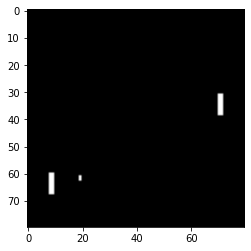

In [34]:
#Show preprocessed

obs_preprocessed = prepro(observation).reshape(80,80)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

In [35]:
#Karpathy Suport class


# reward discount used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def discount_rewards(r, gamma):
  """ take 1D float array of rewards and compute discounted reward """
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0
  # we go from last reward to first one so we don't have to do exponentiations
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
    running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
    discounted_r[t] = running_add
  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem using standar deviation
  return discounted_r


In [36]:
# import necessary modules from keras
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.models import Sequential
import keras
from keras.models import InputLayer
from keras.optimizers import Adam

# creates a generic neural network architecture

"""
The 80 * 80 input dimension comes from the pre-processing of the raw pixels made by Karpathy (the only important pixels are the balls and the paddle)
Input here represents the difference in pixels betewen one frame and another, giving you direction of agents and ball. Encoded in Karpathy's own preprocessing functions

TODO, try adding a 400 layer infront of the 200 unit layer
"""


model = Sequential()

# hidden layer takes a pre-processed frame as input, and has 200 units. Simple layer architectur of 200 x1, 1x1
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))

# output layer - we use a Sigmoid here, in order to get a 0, or 1 value to represent ACTION UP
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))

# compile the model using traditional Machine Learning losses and optimizers
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               1280200   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = []
observation = env.reset()
prev_input = None

#sanity checks
cur_input = prepro(observation)
print(len(cur_input))
x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
prev_input = cur_input
print(x)

proba = model.predict(np.expand_dims(x, axis=1).T)
print(proba)

proba = model.predict(np.expand_dims(x, axis=1).T)
action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
y = 1 if action == 2 else 0

6400
[0. 0. 0. ... 0. 0. 0.]
[[0.5]]


In [37]:
history = []
observation = env.reset()
prev_input = None
# main training loop
while (True):

    """
    Start by preprocessing the observation frame, and then doing the difference with the previous frame. 
    Naturally if frame 1 then we subtract by zeros
    
    X here is the frame-frame difference, Y is the next action (kind of like an RNN). 
    We are trying to predict the next action given two observations.
    """
    cur_input = prepro(observation)
    #print(len(cur_input)) - Sanity Check reasons only
    
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    # forward the policy network and sample action according to the probability distribution
    """
    Running model.predict to know what the current model thinks about the probability of doing the UP_ACTION, 
    given the current frame setting.
    
    Double check size and shape of the array here im pretty sure its for bias term?
    Keras requires a third?? dimension perhaps hre
    """
    
    
    proba = model.predict(np.expand_dims(x, axis=1).T)
    # proba=model.predict(np.expand_dims(x.reshape(80,80), axis=0)) 2D model stuff DELETE
    
    
    #Intorucing another probability distirubtion here, not sure
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == 2 else 0 # 0 and 1 are our labels

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment - This is returned by our environment in OpenAI gym.  
    observation, reward, done, info = env.step(action)
    #Note how AT EACH STEP A REWARD IS CALCULATED. THIS IS NOT EACH GAME BUT EACH FRAME-FRAME DIFFERENCE. 
    #MOST OF THE TIME THIS IS 0
    #THESE REWARDS ARE USED TO ENCOURAGE OR DISCOURAGE MOVEMENTS
    rewards.append(reward)
    reward_sum += reward
    
    """
    rewards : to each frame (x_train[frame_number]) and action (y_train[frame_number]) 
    is associated a reward (-1 if it missed the ball, 0 if nothing happens, and 1 if opponent misses the ball), 
    so we get for instance the following array:
    """
    
    # end of an episode - The GYM also invokes DONE automatically. Invoked when one player reaches 21
    if done:
        
        history.append(reward_sum)
        print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
        if episode_nb>=3000 and reward_sum >=-12:
          break
        else:
          
        
          # increment episode number
          episode_nb += 1
        
          # training
          model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
        
          """
          If an action leads to a positive reward, it tunes the weights of the neural network so 
          it keeps on predicting this winning action.
          Otherwise, it tunes them in the opposite way


          The function discount_rewards transforms the list of rewards 
          so that even actions that remotely lead to positive rewards are encouraged. THIS IS IMPORTANT
          OTHERWISE WE WOULD SIMPLY BE TRYING TO REPLICATE RANDOM MOVEMENTS

          sample_weights is used to provide a weight for each training sample. 
          That means that you should pass a 1D array with the same number of elements as your training samples 
          (indicating the weight for each of those samples. NOTE THIS IS NOT CLASS WEIGHTS
          """
                                                             
          # Reinitialization
          x_train, y_train, rewards = [],[],[]
          observation = env.reset()
          reward_sum = 0
          prev_input = None

At the end of episode 0 the total reward was : -21.0
36/36 [==============================] - 0s 7ms/step - loss: 8.4374e-04 - accuracy: 0.5128
At the end of episode 1 the total reward was : -19.0
36/36 [==============================] - 0s 7ms/step - loss: 0.0071 - accuracy: 0.5443
At the end of episode 2 the total reward was : -21.0
24/24 [==============================] - 0s 7ms/step - loss: 0.0030 - accuracy: 0.5974
At the end of episode 3 the total reward was : -21.0
30/30 [==============================] - 0s 7ms/step - loss: -0.0029 - accuracy: 0.5918
At the end of episode 4 the total reward was : -20.0
35/35 [==============================] - 0s 7ms/step - loss: 0.0087 - accuracy: 0.5675
At the end of episode 5 the total reward was : -21.0
38/38 [==============================] - 0s 7ms/step - loss: -0.0048 - accuracy: 0.5592
At the end of episode 6 the total reward was : -21.0
28/28 [==============================] - 0s 8ms/step - loss: 0.0088 - accuracy: 0.6045
At the end of 

49/49 [==============================] - 0s 7ms/step - loss: -0.0210 - accuracy: 0.9321
At the end of episode 116 the total reward was : -20.0
54/54 [==============================] - 0s 7ms/step - loss: -0.0021 - accuracy: 0.9332
At the end of episode 117 the total reward was : -19.0
53/53 [==============================] - 0s 6ms/step - loss: 0.0098 - accuracy: 0.9327
At the end of episode 118 the total reward was : -19.0
47/47 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 0.9333
At the end of episode 119 the total reward was : -18.0
56/56 [==============================] - 0s 7ms/step - loss: -7.2944e-04 - accuracy: 0.9280
At the end of episode 120 the total reward was : -19.0
42/42 [==============================] - 0s 7ms/step - loss: -0.0135 - accuracy: 0.9332
At the end of episode 121 the total reward was : -18.0
54/54 [==============================] - 0s 8ms/step - loss: -9.5008e-04 - accuracy: 0.9261
At the end of episode 122 the total reward was :

47/47 [==============================] - 0s 7ms/step - loss: 0.0079 - accuracy: 0.9566
At the end of episode 230 the total reward was : -17.0
63/63 [==============================] - 0s 8ms/step - loss: -0.0096 - accuracy: 0.9611
At the end of episode 231 the total reward was : -18.0
72/72 [==============================] - 1s 8ms/step - loss: 7.9393e-04 - accuracy: 0.9584
At the end of episode 232 the total reward was : -19.0
61/61 [==============================] - 0s 7ms/step - loss: 0.0133 - accuracy: 0.9622
At the end of episode 233 the total reward was : -19.0
49/49 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 0.9475
At the end of episode 234 the total reward was : -20.0
64/64 [==============================] - 1s 8ms/step - loss: -0.0038 - accuracy: 0.9529
At the end of episode 235 the total reward was : -19.0
67/67 [==============================] - 1s 8ms/step - loss: -0.0089 - accuracy: 0.9551
At the end of episode 236 the total reward was : -18.0

35/35 [==============================] - 0s 6ms/step - loss: 0.0096 - accuracy: 0.9710
At the end of episode 344 the total reward was : -20.0
54/54 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.9702
At the end of episode 345 the total reward was : -19.0
49/49 [==============================] - 0s 7ms/step - loss: 7.1419e-05 - accuracy: 0.9706
At the end of episode 346 the total reward was : -17.0
51/51 [==============================] - 0s 7ms/step - loss: -0.0040 - accuracy: 0.9724
At the end of episode 347 the total reward was : -20.0
48/48 [==============================] - 0s 7ms/step - loss: -0.0032 - accuracy: 0.9725
At the end of episode 348 the total reward was : -16.0
55/55 [==============================] - 0s 7ms/step - loss: -0.0157 - accuracy: 0.9769
At the end of episode 349 the total reward was : -18.0
48/48 [==============================] - 0s 7ms/step - loss: -8.2131e-04 - accuracy: 0.9674
At the end of episode 350 the total reward was : 

57/57 [==============================] - 0s 7ms/step - loss: -0.0042 - accuracy: 0.9790
At the end of episode 458 the total reward was : -16.0
66/66 [==============================] - 0s 7ms/step - loss: -0.0024 - accuracy: 0.9512
At the end of episode 459 the total reward was : -19.0
59/59 [==============================] - 0s 7ms/step - loss: -0.0094 - accuracy: 0.9712
At the end of episode 460 the total reward was : -14.0
72/72 [==============================] - 1s 7ms/step - loss: -0.0110 - accuracy: 0.9785
At the end of episode 461 the total reward was : -10.0
91/91 [==============================] - 1s 8ms/step - loss: -7.4595e-04 - accuracy: 0.9715
At the end of episode 462 the total reward was : -21.0
55/55 [==============================] - 0s 7ms/step - loss: -0.0097 - accuracy: 0.9724
At the end of episode 463 the total reward was : -19.0
59/59 [==============================] - 0s 7ms/step - loss: 0.0072 - accuracy: 0.9721
At the end of episode 464 the total reward was : -1

59/59 [==============================] - 0s 8ms/step - loss: -0.0048 - accuracy: 0.9738
At the end of episode 570 the total reward was : -15.0
75/75 [==============================] - 1s 8ms/step - loss: -0.0035 - accuracy: 0.9739
At the end of episode 571 the total reward was : -13.0
81/81 [==============================] - 1s 8ms/step - loss: 0.0033 - accuracy: 0.9762
At the end of episode 572 the total reward was : -16.0
58/58 [==============================] - 0s 8ms/step - loss: 0.0062 - accuracy: 0.9794
At the end of episode 573 the total reward was : -12.0
104/104 [==============================] - 1s 8ms/step - loss: -0.0191 - accuracy: 0.9708
At the end of episode 574 the total reward was : -16.0
60/60 [==============================] - 0s 8ms/step - loss: 7.0399e-04 - accuracy: 0.9833
At the end of episode 575 the total reward was : -18.0
50/50 [==============================] - 0s 7ms/step - loss: -0.0118 - accuracy: 0.9762
At the end of episode 576 the total reward was : -1

40/40 [==============================] - 0s 7ms/step - loss: 0.0069 - accuracy: 0.9810
At the end of episode 625 the total reward was : -20.0
48/48 [==============================] - 0s 7ms/step - loss: -6.0249e-04 - accuracy: 0.9732
At the end of episode 626 the total reward was : -20.0
52/52 [==============================] - 0s 8ms/step - loss: -0.0023 - accuracy: 0.9831
At the end of episode 627 the total reward was : -16.0
76/76 [==============================] - 1s 7ms/step - loss: 0.0033 - accuracy: 0.9784
At the end of episode 628 the total reward was : -18.0
64/64 [==============================] - 0s 7ms/step - loss: -0.0062 - accuracy: 0.9773
At the end of episode 629 the total reward was : -12.0
70/70 [==============================] - 1s 9ms/step - loss: -0.0054 - accuracy: 0.9888
At the end of episode 630 the total reward was : -21.0
55/55 [==============================] - 0s 8ms/step - loss: -0.0056 - accuracy: 0.9781
At the end of episode 631 the total reward was : -20

KeyboardInterrupt: 

In [3]:
#Plot results - remember to call keyboard interrupt before this

plt.plot(history)
plt.show()

NameError: name 'history' is not defined

In [43]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display

import gym
from gym import logger as gymlogger
# from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1024, 768))
display.start()

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [27]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [29]:
#Evaluate model on openAi GYM

#To do this consult https://github.com/thinkingparticle/deep_rl_pong_keras/blob/master/reinforcement_learning_pong_keras_policy_gradients.ipynb
env = wrap_env(gym.make('ALE/Pong-v5'))
observation = env.reset()
new_observation = observation
prev_input = None
done = False
while True:
  if True: 
    
    #set input to network to be difference image
  
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
  
    # Sample an action (policy)
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
        
    env.render()
    # Return action to environment and extract
    #next observation, reward, and status
    observation = new_observation
    new_observation, reward, done, info = env.step(action)
    if done: 
      #observation = env.reset()
      break
      
env.close()
show_video()

NameError: name 'Monitor' is not defined

In [37]:
from pyvirtualdisplay.display import Display
print(Display)

<class 'pyvirtualdisplay.display.Display'>
